# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.spectrum import CountsSpectrum
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



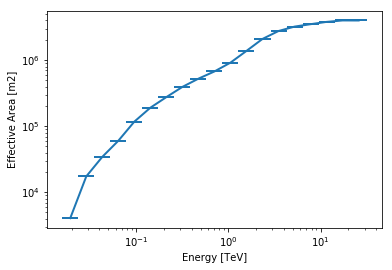

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

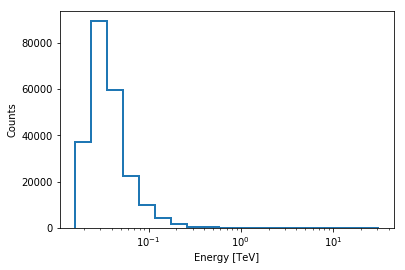

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Flux
flux_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [10]:
#from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
#absorption_model = Absorption.read_builtin('dominguez')
#flux_model = AbsorbedSpectralModel(flux_model, absorption_model, redshift)

In [11]:
dataset = DMDatasetOnOff(
    aeff=aeff,
    model=flux_model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)

In [12]:
dataset.model.jfactor.value

3.41e+19

In [13]:
nuisance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC,
    sigmatau=0.01,
    #width=5,
    #steps=15,
)
dataset.nuisance = nuisance
dataset.check_nuisance() # True if valid values for nuisance are defined in the dataset.

True

**Enable inspection**

In [14]:
import logging
logging.basicConfig()
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")

**The SigmaVEstimator class estimates $\sigma\nu$ for a list of annihilation channels and particle masses.**

In order to have statistics the overall process below is repeated for a given number of `runs`.

- For each run a **random poisson realization** of a `DMDatasetOnOff` is created as a simulated observation.
- For each run we consider a list of annihilation channels.
    - For each channel we consider a list of masses.
        - For each mass in each channel:
            - A specific `DarkMatterAnnihilationSpectralModel` is instantiated with parameters `JFactor`, `channel`, `mass`.
            - This specific annhilation flux model is attached to the `DMDatasetOnOff` dataset instance.
            - A fit of this specific annhilation model to the simulated observation of the run is performed for each of the `steps` values that the nuisance parameter `j` takes in a range of ± `sigmaj` * `width`. 
            - A fit is chosen: the one giving the minimum value for the likelihood.
            - A check (L<sub>0</sub> - L<sub>min</sub> ≤ 25) is done.
            - A value of the scale parameter `sv` giving ΔL=2.71 in the likelihood profile is chosen.
            - If the value of `sv` is not in the range of the physical region (>=0) or does not reach ΔL=2.71 we skip the run and take the next one.
            -  $\sigma\nu$  is the chosen value of `sv`is multiplied by the thermal relic cross section.

- Profile likelihoods and values calculated for `sv` and $\sigma\nu$ are provided for each run, channel and mass.
- For each channel a table of mean values across all runs of $\sigma\nu$ vs. mass is provided. 
- Messages are displayed according to the logging level sonfiguration defined.

**Instatiate estimator**

In [15]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels, background_model=bkg, jfactor=JFAC)

**Run estimator and fetch results**

In [16]:
%%time
#likelihood_profile_opts=dict(bounds=50, nvalues=50)
result = estimator.run(runs=2, nuisance=True)
#if nuisance = True the process takes the nuisance parameters into account.

INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 105.29730092060726
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 105.29726708943409
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 105.29725487107554
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 105.29724637760847
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 105.29724067531502
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 105.29723711265686
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 105.29723522028569
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 105.29723465144957
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 105.29723514447093
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 105.2972364982674

DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 106.59827421876719
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 106.59827471178855
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 106.59827606558503
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 106.59827812299463
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 106.5982807602754
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 106.59828387779733
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 106.5982873951265
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 106.59829124657743
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 3.707643747176128
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 106.59827421876719
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 3.707643747176128
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 984.37762342

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -1.2890603304617603
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 106.75120744687204
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 216.5226147644115
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 7580.4046 	| Max:  7689.865777250213
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 106.75120744687204
INFO:gammapy.astro.darkmatter.utils:Sigma v:7.606387615649415e-26
INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 106.72853389848073
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 106.72851074144323
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 106.72849852432753
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 106.72849003086047
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likeliho

DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 106.33513512081575
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 106.33512290370005
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 106.33511441023299
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 106.33510870793954
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 106.33510514528137
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 106.3351032529102
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 106.33510268407409
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 106.33510317709545
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 106.33510453089193
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 106.33510658851631
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 106.33510922579708
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min 

DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 106.7414052150626
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 106.74140727268698
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 106.74140990996776
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 106.74141302748968
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 106.74141654481886
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 106.74142039626979
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 0.19417338377213567
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 106.74140336824476
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0.19417338377213567
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 872.6307141736623
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 6804.4155 	| Max:  6913.866901073242
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: -0.0016 	| Zero: 106.739832

DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 7.325794290486029
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 115.21120714496791
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 7.325794290486029
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 2773.453557663779
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 8630.0953 	| Max:  8748.016473201036
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0669 	| Zero: 115.27807265842523
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.5872779261615645e-24
INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 115.21915638342327
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 115.21913905213987
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 115.21912683315256
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 115.21911833917719
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 115.21911263649974
DEBUG:gammapy.as

DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 115.03842572270864
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 115.0384135015755
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 115.03840500810844
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 115.03839930581499
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 115.03839574315683
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 115.03839385078565
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 115.03839328194954
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 115.0383937749709
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 115.03839512876738
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 115.03839718639176
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 115.03839982367253
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min L

DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 111.64277602784867
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 111.64277738164515
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 111.64277943926953
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 111.6427820765503
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 111.64278519407225
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 111.64278871140141
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 111.64279256285235
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 3.3598831320022624
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 111.64277553482731
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 3.3598831320022624
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 180.74876885444706
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 5888.5674 	| Max:  6002.9201

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -27.94691062616564
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 115.11451412710811
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 757.6659051186119
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 207.6097 	| Max:  325.4341971750439
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 115.11451412710811
INFO:gammapy.astro.darkmatter.utils:Sigma v:6.751610494022434e-25
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 115.25102390336784
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 115.25100657365054
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 115.25099435653485
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 115.25098586306778
DEBUG:gammapy.astr

DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 114.79964892183489
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 114.79963157750683
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 114.79961936001479
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 114.79961086483897
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 114.79960516254553
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 114.79960159938963
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 114.79959970701846
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 114.79959913818234
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 114.7995996312037
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 114.79960098500018
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 114.79960304262457
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min 

CPU times: user 1min 49s, sys: 2.06 s, total: 1min 51s
Wall time: 1min 53s


## Inspection of results

**Display results for channel b and run 0**

In [17]:
cols = ["mass", "sigma_v", "sv_best", "sv_ul", "statprofile"]
result["runs"]["b"][0][cols]

mass,sigma_v,sv_best,sv_ul,statprofile
GeV,cm3 / s,,,
float64,float64,float64,float64,object
100.0,6.951537937611156e-25,0.0,23.171793125370517,"{'values': array([-2791.6868964 , -2679.09529279, -2566.50368917, -2453.91208555, -2341.32048193, -2228.72887832, -2116.1372747 , -2003.54567108, -1890.95406747, -1778.36246385, -1665.77086023, -1553.17925661, -1440.587653 , -1327.99604938, -1215.40444576, -1102.81284214, -990.22123853, -877.62963491, -765.03803129, -652.44642767, -539.85482406, -427.26322044, -314.67161682, -202.0800132 , -89.48840959, 23.10319403, 135.69479765, 248.28640126, 360.87800488, 473.4696085 , 586.06121212, 698.65281573, 811.24441935, 923.83602297, 1036.42762659, 1149.0192302 , 1261.61083382, 1374.20243744, 1486.79404106, 1599.38564467, 1711.97724829, 1824.56885191, 1937.16045553, 2049.75205914, 2162.34366276, 2274.93526638, 2387.52686999, 2500.11847361, 2612.71007723, 2725.30168085]), 'stat': array([11921.14894631, 10919.15818381, 9965.39584284, 9059.34698627, 8200.49951909, 7388.34445752, 6622.37588037, 5902.09046006, 5226.98644235, 4596.56191272, 4010.31215608, 3467.72589705, 2968.28022843, 2511.43415207, 2096.62097158, 1723.24040532, 1390.6522259 , 1098.17410104, 845.08636914, 630.64544595, 454.10687562, 314.69076445, 211.33246417, 143.18817812, 109.47670788, 109.44677074, 142.37990493, 207.59075513, 304.42569463, 432.26063856, 590.49861626, 778.56740855, 995.91738324, 1242.01956945, 1516.36396759, 1818.45807424, 2147.82559566, 2504.00532387, 2886.55015121, 3295.02620234, 3729.01206561, 4188.09810873, 4671.88586579, 5179.98748509, 5712.02522896, 6267.63101819, 6846.44601491, 7448.12023887, 8072.31221281, 8718.68863339])}"
200.0,4.551025615508257e-25,0.0,15.170085385027523,"{'values': array([-1710.98999428, -1641.89419976, -1572.79840524, -1503.70261072, -1434.60681619, -1365.51102167, -1296.41522715, -1227.31943263, -1158.22363811, -1089.12784359, -1020.03204906, -950.93625454, -881.84046002, -812.7446655 , -743.64887098, -674.55307646, -605.45728194, -536.36148741, -467.26569289, -398.16989837, -329.07410385, -259.97830933, -190.88251481, -121.78672028, -52.69092576, 16.40486876, 85.50066328, 154.5964578 , 223.69225232, 292.78804684, 361.88384137, 430.97963589, 500.07543041, 569.17122493, 638.26701945, 707.36281397, 776.45860849, 845.55440302, 914.65019754, 983.74599206, 1052.84178658, 1121.9375811 , 1191.03337562, 1260.12917015, 1329.22496467, 1398.32075919, 1467.41655371, 1536.51234823, 1605.60814275, 1674.70393727]), 'stat': array([11551.37827794, 10594.8119781 , 9682.7933304 , 8814.92866612, 7990.83109257, 7210.12046681, 6472.42319725, 5777.37181362, 5124.60422434, 4513.76255185, 3944.49139554, 3416.43531844, 2929.2352891 , 2482.52376009, 2075.91811295, 1709.01254386, 1381.36939974, 1092.51256575, 841.92687079, 629.06692241, 453.37665243, 314.32297213, 211.36306753, 143.43004139, 109.77275781, 109.74706647, 142.73665446, 208.15597152, 305.44956381, 434.08973777, 593.57372513, 783.42088066, 1003.17012467, 1252.37770359, 1530.61527679, 1837.46830487, 2172.53470062, 2535.4237012 , 2925.75492268, 3343.15756364, 3787.26972985, 4257.73785748, 4754.21621666, 5276.36648073, 5823.85734964, 6396.36421806, 6993.5688808 , 7615.15926937, 8260.8292149 , 8930.27823324])}"
500.0,3.436753832981549e-25,0.0,11.455846109938495,"{'values': array([-1173.00340769, -1125.54857855, -1078.09374942, -1030.63892028, -983.18409115, -935.72926201, -888.27443288, -840.81960374, -793.36477461, -745.90994547, -698.45511634, -651.0002872 , -603.54545807, -556.09062893, -508.6357998 , -461.18097066, -413.72614153, -366.27131239, -318.81648326, -271.36165412, -223.90682499, -176.45199585, -128.99716672, -81.54233758, -34.08750845, 13.36732069, 60.82214982, 108.27697896, 155.73180809, 203.18663723, 250.64146636, 298.0962955 , 345.55112463, 393.00595377, 440.4607829 , 487.91561204, 535.37044117, 582.82527031, 630.28009944, 677.73492858, 725.18975771, 772.64458685, 820.09941598, 867.55424512, 915.00907425, 962.46390339, 1009.91873252, 1

**Plot likelihood profile for a specific fit**

In [18]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["b"][0]["statprofile"][idx][0][0]

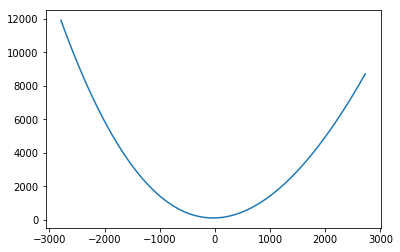

In [19]:
plt.plot(profile["values"], profile["stat"]);

## Plot obtained results for sigma

In [20]:
result["mean"]["b"]

mass,sigma_v,std
GeV,cm3 / s,cm3 / s
float64,float64,float64
100.0,1.14121585996134e-24,4.4606206620022445e-25
200.0,7.106604351315268e-25,2.555578735807011e-25
500.0,6.052033056328193e-25,2.6152792233466435e-25
1000.0,6.484564655421051e-25,2.8122176476896134e-25
5000.0,7.014377368018775e-25,1.0246522369530357e-25
10000.0,6.675865230529962e-25,1.1391296292139325e-25
50000.0,1.185138256267995e-24,4.66374059487601e-25


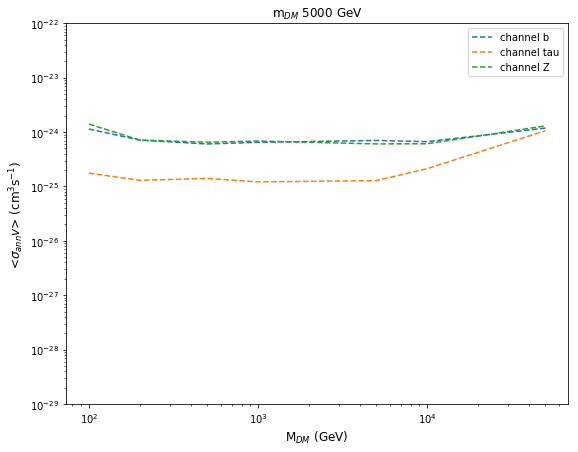

In [21]:
plt.figure(figsize=(9,7))
plt.ylim(1e-29, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();